# May 3-4, 13-18, 2022: Idea1: don't care labels: create dataset

Create input samples and targets with three classes: appr, retr, unidentifiable

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/may22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions
import data.emoprox2.scripts.stimulus_utils as stimulus_utils

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-05-21 17:25:19.139559: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-21 17:25:21.251708: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-21 17:25:21.281221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-21 17:25:21.281503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-21 17:25:21.281539: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## main data creation and storage

In [2]:
APPR, RETR = 1, 0
MASK = -100 #0.5
MIN_SEG_LEN = 5 # remove segments shorter than this TR-length

with open(f"{proj_dir}/data/emoprox2/subj_wise_stimuli.pkl", 'rb') as f:
    tr_dfs = pickle.load(f)

interim_path = '/home/joyneelm/approach-retreat/data/interim'
# cortical_path = f"{interim_path}/CON{subj}/CON{subj}_cortical_meanTS.1D"
# max_roi_path = f"{interim_path}/CON{subj}/CON{subj}_MAX_rois_meanTS.1D"

def get_run_list(subj_dfs):
    run_list = []
    for idx, df in enumerate(subj_dfs):
        if df is None: continue
        run_list.append(idx)
    return run_list, len(subj_dfs[run_list[0]])

def get_data_samples(ts, contig_regions, label):
    for region in contig_regions:
        x = ts[region[0]:region[1]]
        if x.shape[0] <= MIN_SEG_LEN: continue
        X.append(x)
        y.append([label]*x.shape[0])

In [3]:
data_file = f"{proj_dir}/data/emoprox2/idea1_data.pkl"
if os.path.exists(data_file):
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

else:
    data = {}
    for subj, subj_dfs in tqdm(tr_dfs.items()):
        X = []
        y = []
        
        # targets
        # subj_dfs = tr_dfs[subj]

        # fMRItime series
        max_roi_path = f"{interim_path}/CON{subj}/CON{subj}_MAX_rois_meanTS.1D"
        ts_path = max_roi_path
        subj_ts = np.loadtxt(ts_path)

        # assure that number of runs are same in input ts and targets
        run_list, RUN_LEN = get_run_list(subj_dfs)
        num_runs = subj_ts.shape[0] // RUN_LEN
        assert(num_runs == len(run_list))

        # separate run-wise ts
        subj_ts_list = np.split(subj_ts, num_runs, axis=0)

        for idx_run, run in enumerate(run_list):

            # create segments of uncontaminated appr/retr periods
            df = subj_dfs[run]
            eps = 0.1

            appr_segs = ((df['appr_conv'] > df['retr_conv'] + eps) & (df['appr_conv'] > 0.5) & (df['shock_censor'] != np.nan)).values 
            retr_segs = ((df['retr_conv'] > df['appr_conv'] + eps) & (df['retr_conv'] > 0.5) & (df['shock_censor'] != np.nan)).values 
            # dont_know_segs = (1.0 - (appr_segs + retr_segs)) * (df['shock_censor'] != np.nan).values

            appr_contig_regions = dataset_utils.contiguous_regions(appr_segs)
            retr_contig_regions = dataset_utils.contiguous_regions(retr_segs)
            # dont_know_contig_regions = dataset_utils.contiguous_regions(dont_know_segs)

            get_data_samples(subj_ts_list[idx_run], appr_contig_regions, APPR)
            get_data_samples(subj_ts_list[idx_run], retr_contig_regions, RETR)
        
        # collect 
        data[subj] = {'X': X, 'y':y}
        

    # save the data 
    with open(data_file, 'wb') as f:
        pickle.dump(data, f)

## training and testing datasets

In [4]:
def get_data(data, subject_list):
    X = [] 
    y = []
    Xlen = [] 
    global MASK

    for subject in subject_list:
        X += data[subject]['X']
        y += data[subject]['y']
        Xlen += [i.shape[0] for i in data[subject]['X']]

    X_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X, 
        padding="post",
        dtype='float', 
        value=MASK
    )
    
    y_padded = tf.keras.preprocessing.sequence.pad_sequences(
        y, 
        padding="post",
        dtype='float',
        value=MASK
    )
    # y_padded = tf.convert_to_tensor(y)

    return X_padded, y_padded, Xlen

In [5]:
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train


subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
 len_train) = get_data(data, train_list)
(X_test, y_test, 
 len_test) = get_data(data, test_list)
# y_test = tf.keras.utils.to_categorical(y_test)
# y_train = tf.keras.utils.to_categorical(y_train)

## plots

### typical target vectors: `[batch, time]`

(10154, 8, 85) (10154, 8)


Text(0.5, 0, 'timesteps')

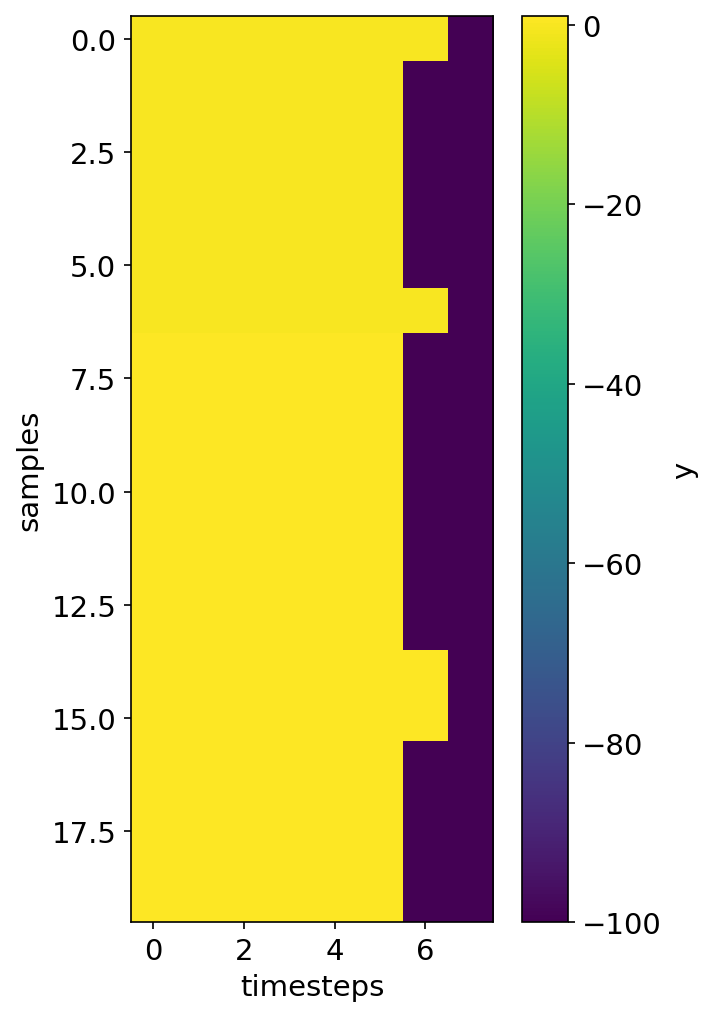

In [6]:
print(X_train.shape, y_train.shape)

cbar_kw={
    'location':'right', 'shrink':1.0, 
    'label':f"", 'pad':0.05, 
    'anchor':(0.0,1.0)
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 8), dpi=150)
im = ax.imshow(y_train[20:40, :])
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(f"y")#, rotation=-90, va="bottom")
ax.set_ylabel(f"samples")
ax.set_xlabel(f"timesteps")

### input timeseries: `[batch, time, rois]`
Inspect if the appr/retr timeseries are different, visually and statistically.

In [7]:
def get_conds_per_subj(subj, data):
    y = tf.keras.preprocessing.sequence.pad_sequences(
        data[subj]['y'],
        maxlen=8,
        padding='post',
        dtype='float',
        value=MASK
    )
    X = tf.keras.preprocessing.sequence.pad_sequences(
        data[subj]['X'], 
        maxlen=8,
        padding='post', 
        dtype='float',
        value=MASK
    )

    X = np.ma.masked_where(X == MASK, X)
    
    X_appr = X[y[:, 0]==APPR, ...]
    X_retr = X[y[:, 0]==RETR, ...]
    X_conds['appr'].append(np.ma.mean(X_appr, axis=0))
    X_conds['retr'].append(np.ma.mean(X_retr, axis=0))

subj_list = list(data.keys())
X_conds = {'appr':[], 'retr':[]}
for subj in subj_list:
    get_conds_per_subj(subj, data)

for k, v in X_conds.items():
    X_conds[k] = np.stack(v, axis=0)

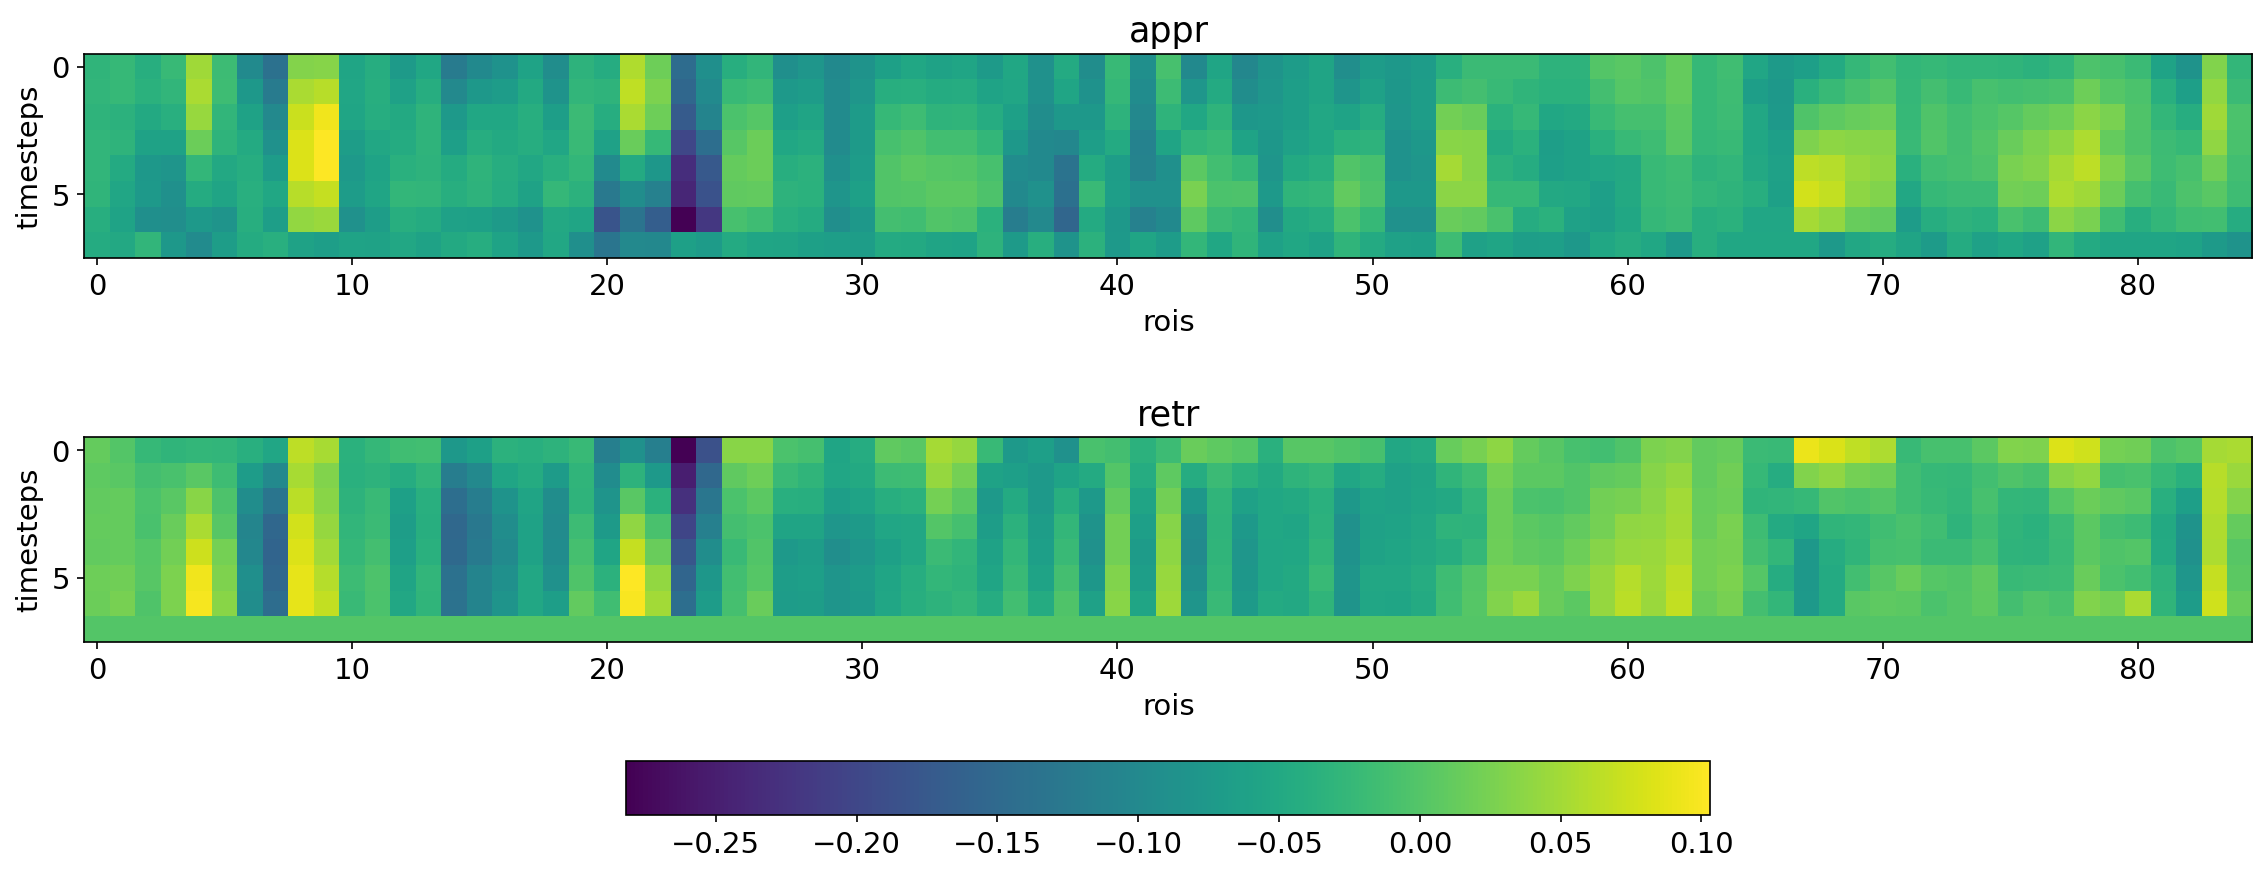

In [8]:
fig, axs = plt.subplots(
    nrows=2, ncols=1, 
    figsize=(15, 6), dpi=150,
    constrained_layout=True)

# APPR
ax = axs[0] 
# cbar_kw={
#     'location':'bottom', 'shrink':1.0, 
#     'label':f"APPR", 'pad':0.2, 
#     'anchor':(0.0,1.0)
# }
im = ax.imshow(np.ma.mean(X_conds['appr'], axis=0))
# cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
# cbar.ax.set_ylabel(f"APPR", rotation=-90, va="bottom")
ax.set_ylabel(f"timesteps")
ax.set_xlabel(f"rois")
ax.set_title(f"appr")

# RETR
ax = axs[1] 
# cbar_kw={
#     'location':'bottom', 'shrink':1.0, 
#     'label':f"RETR", 'pad':0.2, 
#     'anchor':(0.0,1.0)
# }
im = ax.imshow(np.ma.mean(X_conds['retr'], axis=0))
# cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
# cbar.ax.set_ylabel(f"RETR", rotation=-90, va="bottom")
ax.set_ylabel(f"timesteps")
ax.set_xlabel(f"rois")
ax.set_title(f"retr")

cbar = fig.colorbar(im, ax=axs, shrink=0.5, location='bottom')

In [9]:
roi_name_file = (
    f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
)
roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

X = {}
for cond, ts in X_conds.items():
    X[f"{cond}_m"] = np.ma.mean(ts, axis=0)
    X[f"{cond}_s"] = 1.96 * np.ma.std(ts, axis=0) / np.sqrt(ts.shape[0])

time = np.arange(8)

## NORMALIZE/ STANDARDIZE TIMESERIES DATA

In [10]:
for cond in X_conds.keys():
    print(np.ma.mean(X_conds[cond]))
    print(np.ma.std(X_conds[cond]))

0.008564528465527337
0.18991119513115304
-0.01980478325520446
0.1588597347173654


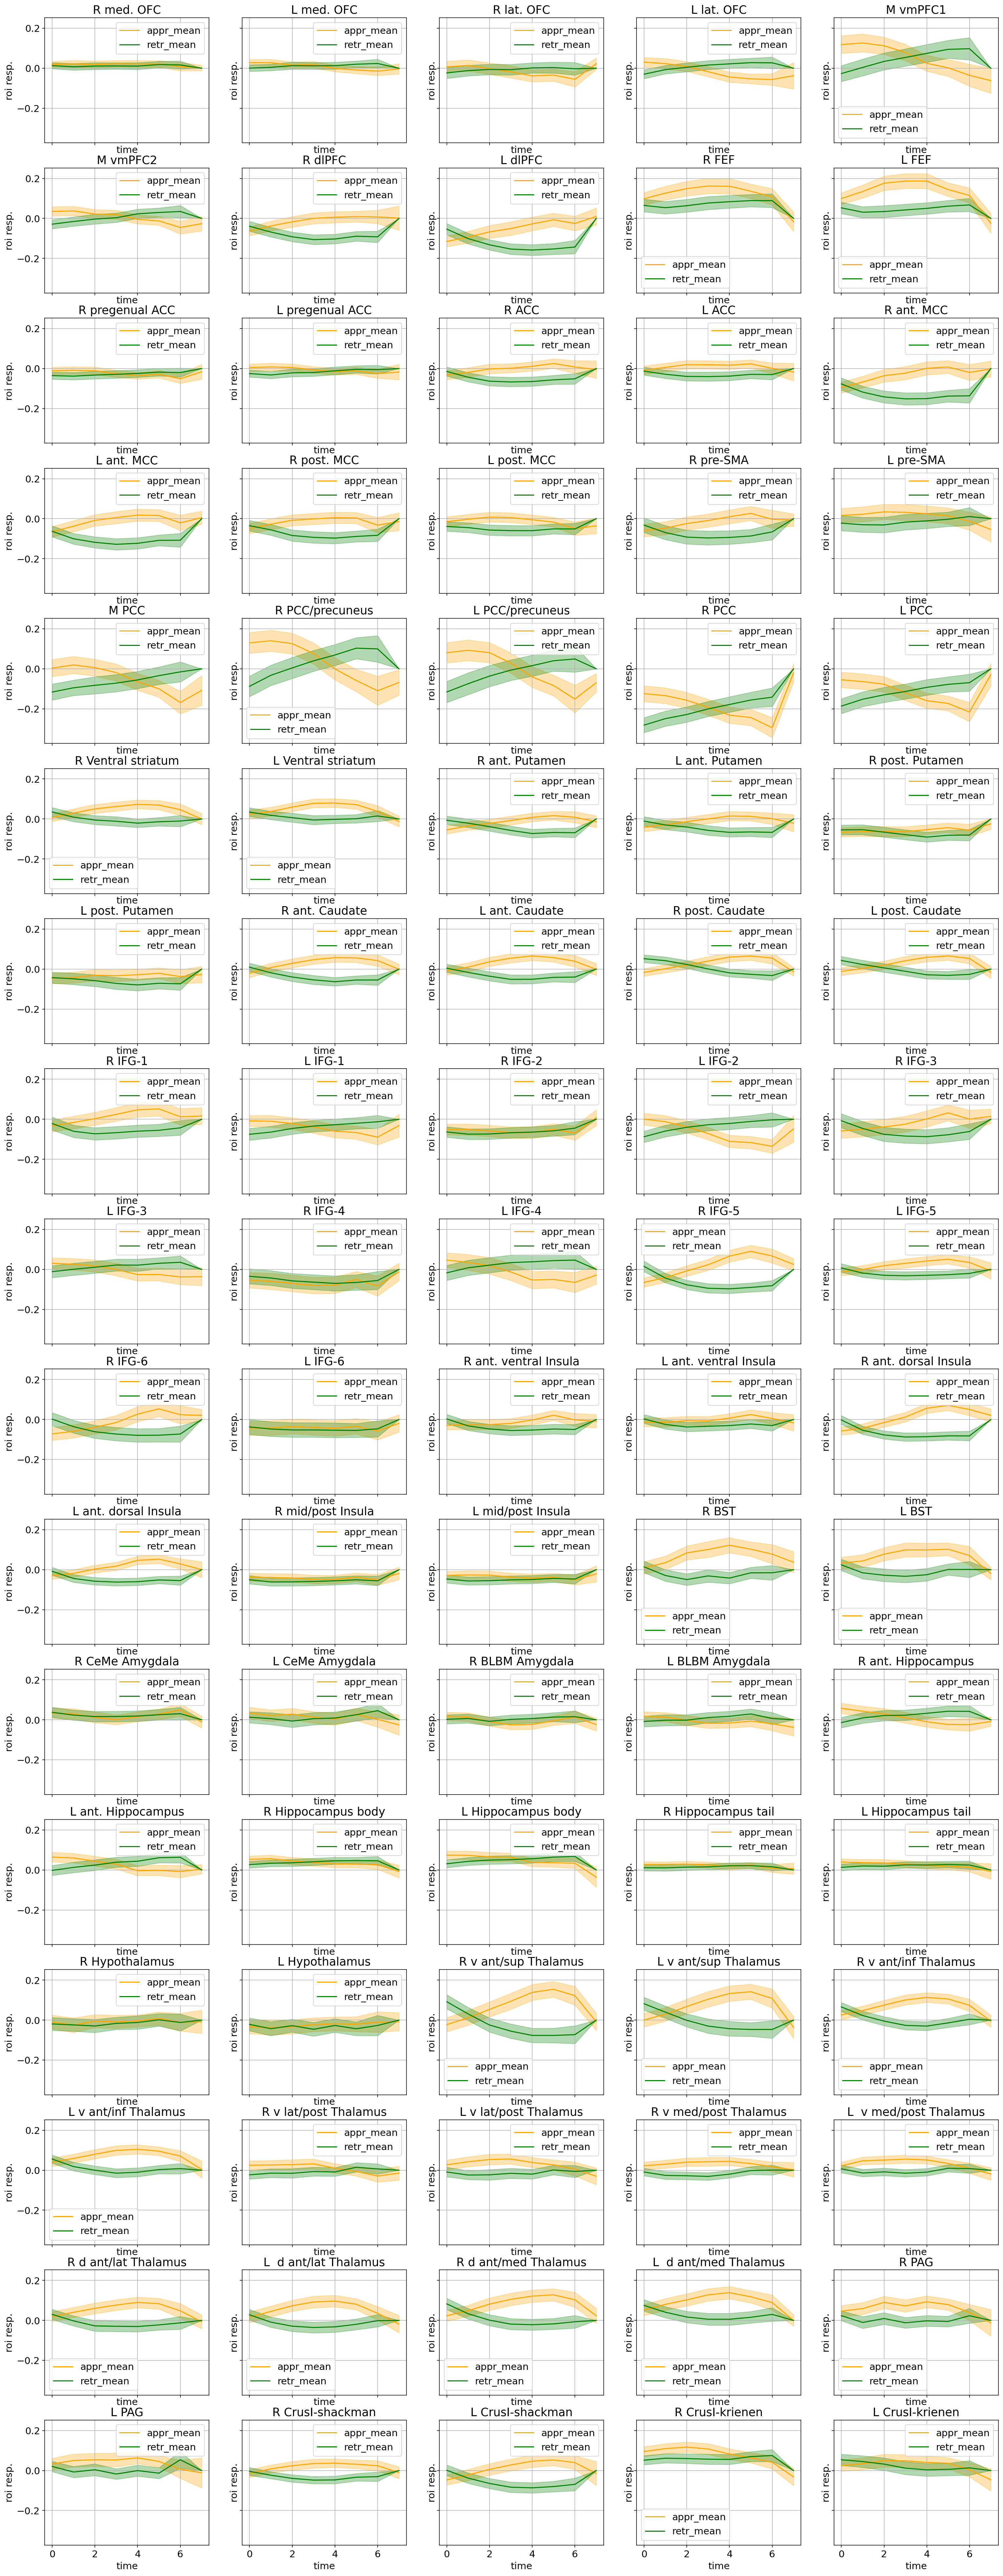

In [11]:
colors = {'appr':'orange', 'retr':'green'}
nrows, ncols = 17, 5
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=150
)
for idx_roi, roi_name in enumerate(roi_names):
    ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

    ax.set_title(f"{roi_name}")
    for cond in X_conds.keys():
        ts_mean = X[f"{cond}_m"][:, idx_roi]
        ts_std = X[f"{cond}_s"][:, idx_roi]
        ax.plot(ts_mean, color=colors[cond], label=f"{cond}_mean")

        ax.fill_between(
            time, 
            (ts_mean - ts_std),
            (ts_mean + ts_std),
            alpha=0.3, color=colors[cond]
        )
    ax.set_xlabel(f"time")
    ax.set_ylabel(f"roi resp.")
    ax.grid(True)
    ax.legend()

### creating nifti files

In [12]:
def plot_roi_vec_on_niimg(roi_data, mask):
    # create an empty stat img
    stat_img_all_rois = image.new_img_like(ref_niimg=mask, 
                                           data=np.zeros_like(mask.get_fdata()[..., None], 
                                                              dtype=np.float32), 
                                           copy_header=True)
    
    # unmask roi value on all voxels of the roi
    for idx_roi in tqdm(np.arange(roi_data.shape[-1])):
        mask_roi = image.math_img(f"img=={idx_roi+1}", img=mask)
        num_voxels = np.where(mask_roi.get_fdata())[0].shape[0]
        vox_data = roi_data[:, idx_roi][:, None] @ np.ones(shape=(num_voxels,))[None, :] # time x voxels
        stat_img = masking.unmask(vox_data, mask_img=mask_roi)
        stat_img_all_rois = image.math_img(f"img_all+img_roi", 
                                           img_all=stat_img_all_rois, 
                                           img_roi=stat_img)
        
    return stat_img_all_rois

mask_file = f"/home/govindas/parcellations/templates/MAX_ROIs_final_gm_85.nii.gz"
# print(mask_file)
mask = image.load_img(mask_file)

In [13]:
# for cond, ts in X_conds.items():
#     print(cond)
#     stat_img_all_rois = plot_roi_vec_on_niimg(
#         roi_data=np.ma.mean(ts, axis=0),
#         mask=mask
#     )
#     cond_nifti_file = f"{month_dir}/idea1_{cond}_ts.nii.gz"
#     # print(appr_nifti_file)
#     stat_img_all_rois.to_filename(cond_nifti_file)